In [25]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics
import sklearn as sk
from sklearn.linear_model import LinearRegression

In [26]:
# Import and Clean data
data = pd.read_csv('2015-2017_daily_weather_records.csv')
del data['Unnamed: 0']
data.info()

# Remove all days with 0 rainfall
#full_data.loc[full_data['daily_rainfall_total'] != 0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   daily_rainfall_total      840 non-null    float64
 1   highest_30_min_rainfall   840 non-null    float64
 2   highest_60_min_rainfall   840 non-null    float64
 3   highest_120_min_rainfall  840 non-null    float64
 4   mean_temperature          840 non-null    float64
 5   maximum_temperature       840 non-null    float64
 6   minimum_temperature       840 non-null    float64
 7   mean_wind_speed           840 non-null    float64
 8   max_wind_speed            840 non-null    float64
 9   rain_binary               840 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 65.8 KB


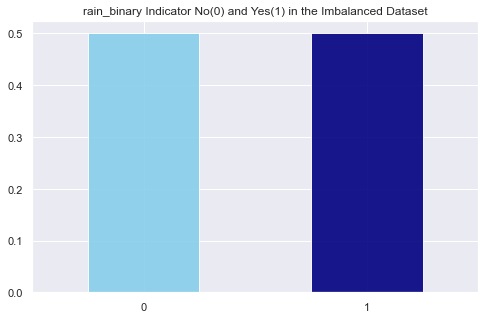

In [27]:
# Check if data is balanced/inbalanced
fig = plt.figure(figsize = (8,5))
data.rain_binary.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('rain_binary Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

In [28]:
# Detect outliers
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)

IQR = Q3 - Q1

# Removing Outliers
use_data = data[~((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)]
use_data.shape

(612, 10)

<ipython-input-29-fb38706de451>:4: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



<AxesSubplot:>

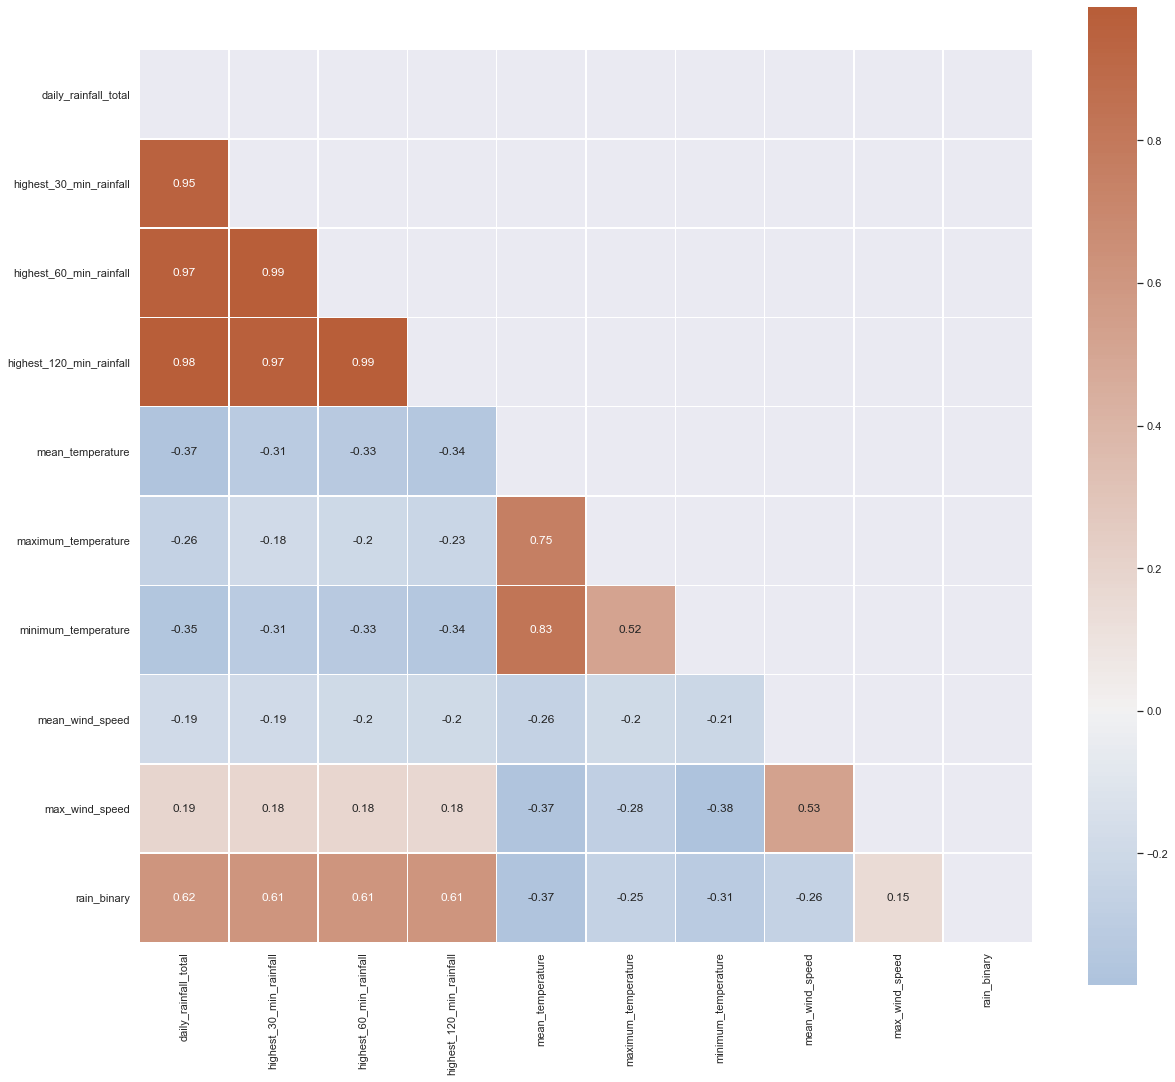

In [29]:
# Correlation heatmap

corr = use_data.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sb.diverging_palette(250, 25, as_cmap=True)
sb.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

C:\Users\ForTh\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning:

Dataset has 0 variance; skipping density estimate.

C:\Users\ForTh\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning:

Dataset has 0 variance; skipping density estimate.

C:\Users\ForTh\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning:

Dataset has 0 variance; skipping density estimate.

C:\Users\ForTh\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning:

Dataset has 0 variance; skipping density estimate.



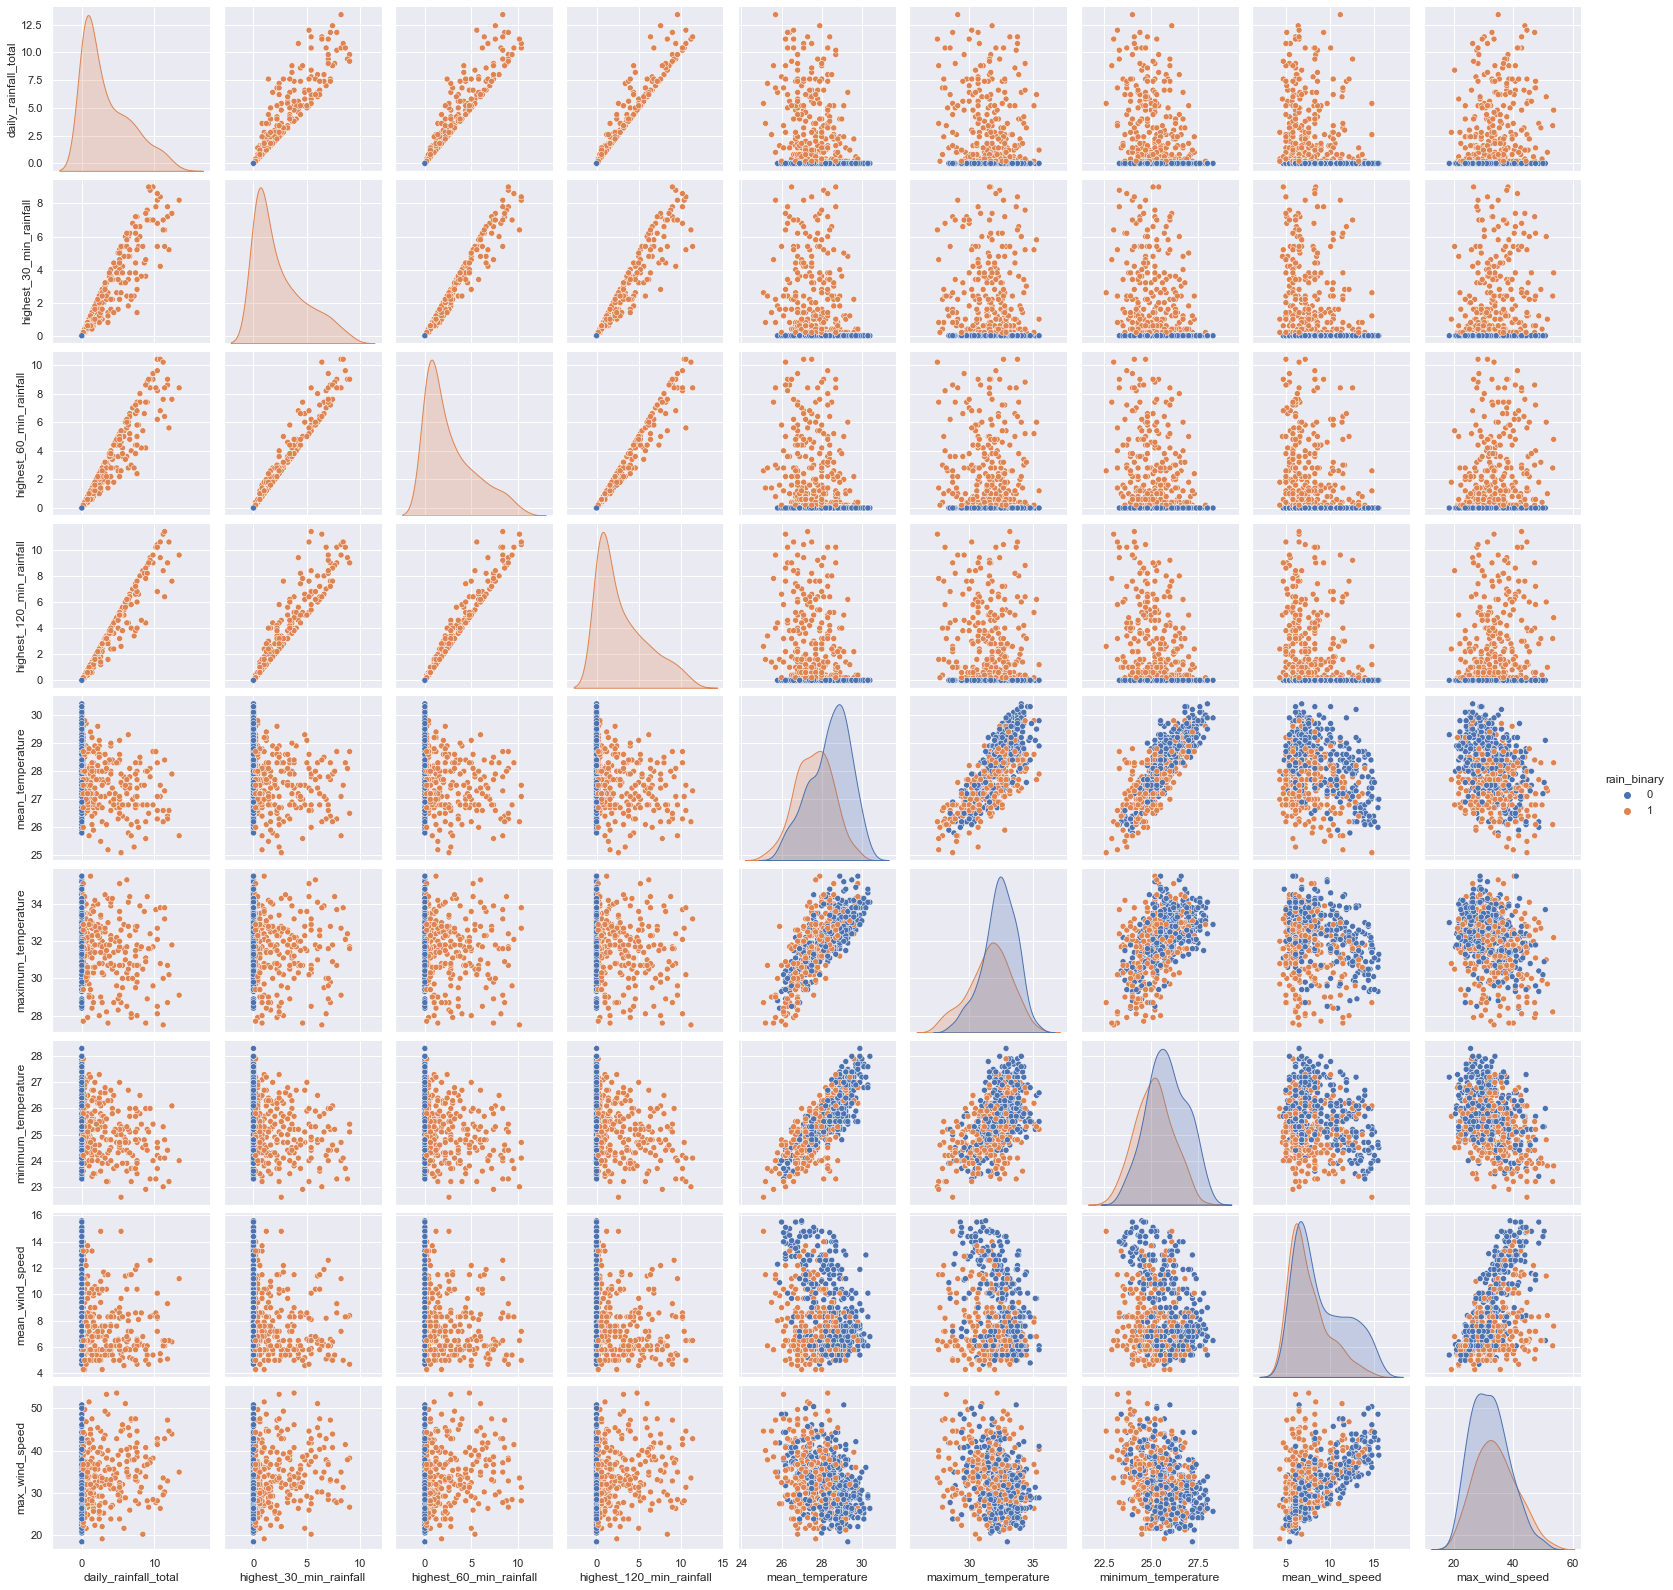

In [33]:
sb.pairplot( data=use_data, vars=('daily_rainfall_total','highest_30_min_rainfall','highest_60_min_rainfall','highest_120_min_rainfall', 'mean_temperature', 'maximum_temperature','minimum_temperature','mean_wind_speed','max_wind_speed'), hue='rain_binary')

In [34]:
# Selection of features by wrapping method (random forest):
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf

X = use_data.drop('rain_binary', axis=1)
y = use_data['rain_binary']
selector = SelectFromModel(rf(n_estimators=100, random_state=0))
selector.fit(X, y)
support = selector.get_support()
features = X.loc[:,support].columns.tolist()
print(features)
print(rf(n_estimators=100, random_state=0).fit(X,y).feature_importances_)

['daily_rainfall_total', 'highest_30_min_rainfall', 'highest_60_min_rainfall', 'highest_120_min_rainfall']
[0.18705728 0.35791037 0.21590308 0.22537486 0.00970881 0.
 0.00268582 0.00135977 0.        ]


In [35]:
# Setting up train and test 
features = use_data[['daily_rainfall_total','highest_30_min_rainfall','highest_60_min_rainfall','highest_120_min_rainfall', 
                        'mean_temperature', 'maximum_temperature','minimum_temperature','mean_wind_speed','max_wind_speed']]
target = use_data['rain_binary']

# Split into test and train - 75% test, 25% train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

# Normalize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [23]:
import catboost as catboost
from catboost import CatBoostRegressor

booster = CatBoostRegressor(iterations=1000, verbose=10)

booster.fit(X_train, y_train, eval_set=(X_test, y_test))
booster.set_feature_names(use_data)

test_preds = booster.predict(X_test)
train_preds = booster.predict(X_train)

from catboost.utils import eval_metric

print("\nTest  R2 : %.2f"%booster.score(X_test, y_test))
print("Train R2 : %.2f"%booster.score(X_train, y_train))

Learning rate set to 0.045061
0:	learn: 0.4716195	test: 0.4826418	best: 0.4826418 (0)	total: 16.2ms	remaining: 16.2s
10:	learn: 0.3080304	test: 0.3582477	best: 0.3582477 (10)	total: 19.8ms	remaining: 1.78s
20:	learn: 0.2026881	test: 0.2959187	best: 0.2959187 (20)	total: 23.5ms	remaining: 1.1s
30:	learn: 0.1337405	test: 0.2695228	best: 0.2695228 (30)	total: 27.2ms	remaining: 849ms
40:	learn: 0.0876009	test: 0.2597064	best: 0.2597064 (40)	total: 30.9ms	remaining: 722ms
50:	learn: 0.0580608	test: 0.2573912	best: 0.2573912 (50)	total: 34.7ms	remaining: 646ms
60:	learn: 0.0391810	test: 0.2576243	best: 0.2572464 (54)	total: 38.7ms	remaining: 595ms
70:	learn: 0.0271724	test: 0.2583141	best: 0.2572464 (54)	total: 42.4ms	remaining: 555ms
80:	learn: 0.0196974	test: 0.2591351	best: 0.2572464 (54)	total: 46.1ms	remaining: 524ms
90:	learn: 0.0150577	test: 0.2598329	best: 0.2572464 (54)	total: 49.9ms	remaining: 499ms
100:	learn: 0.0121588	test: 0.2603065	best: 0.2572464 (54)	total: 53.7ms	remaining:

In [22]:
booster.plot_predictions(X_test[:5], features_to_change=["daily_rainfall_total"]);